In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import pickle as pk
import os

import keras
import keras.backend as K
from keras.models import load_model
from keras import optimizers

import lightgbm as lgb

def mish(x):
    return x*K.tanh(K.softplus(x))

class Lookahead(keras.optimizers.Optimizer):
    """The lookahead mechanism for optimizers.
    Default parameters follow those provided in the original paper.
    # Arguments
        optimizer: An existed optimizer.
        sync_period: int > 0. The synchronization period.
        slow_step: float, 0 < alpha < 1. The step size of slow weights.
    # References
        - [Lookahead Optimizer: k steps forward, 1 step back]
          (https://arxiv.org/pdf/1907.08610v1.pdf)
    """

    def __init__(self, optimizer, sync_period=5, slow_step=0.5, **kwargs):
        super(Lookahead, self).__init__(**kwargs)
        self.optimizer = keras.optimizers.get(optimizer)
        with K.name_scope(self.__class__.__name__):
            self.sync_period = K.variable(sync_period, dtype='int64', name='sync_period')
            self.slow_step = K.variable(slow_step, name='slow_step')

    @property
    def lr(self):
        return self.optimizer.lr

    @lr.setter
    def lr(self, lr):
        self.optimizer.lr = lr

    @property
    def learning_rate(self):
        return self.optimizer.learning_rate

    @learning_rate.setter
    def learning_rate(self, learning_rate):
        self.optimizer.learning_rate = learning_rate

    @property
    def iterations(self):
        return self.optimizer.iterations

    def get_updates(self, loss, params):
        sync_cond = K.equal((self.iterations + 1) // self.sync_period * self.sync_period, (self.iterations + 1))
        slow_params = {p.name: K.variable(K.get_value(p), name='sp_{}'.format(i)) for i, p in enumerate(params)}
        update_names = ['update', 'update_add', 'update_sub']
        original_updates = [getattr(K, name) for name in update_names]
        setattr(K, 'update', lambda x, new_x: ('update', x, new_x))
        setattr(K, 'update_add', lambda x, new_x: ('update_add', x, new_x))
        setattr(K, 'update_sub', lambda x, new_x: ('update_sub', x, new_x))
        self.updates = self.optimizer.get_updates(loss, params)
        for name, original_update in zip(update_names, original_updates):
            setattr(K, name, original_update)
        slow_updates = []
        for i, update in enumerate(self.updates):
            if isinstance(update, tuple):
                name, x, new_x, adjusted = update + (update[-1],)
                update_func = getattr(K, name)
                if name == 'update_add':
                    adjusted = x + new_x
                if name == 'update_sub':
                    adjusted = x - new_x
                if x.name not in slow_params:
                    self.updates[i] = update_func(x, new_x)
                else:
                    slow_param = slow_params[x.name]
                    slow_param_t = slow_param + self.slow_step * (adjusted - slow_param)
                    slow_updates.append(K.update(slow_param, K.switch(
                        sync_cond,
                        slow_param_t,
                        slow_param,
                    )))
                    self.updates[i] = K.update(x, K.switch(
                        sync_cond,
                        slow_param_t,
                        adjusted,
                    ))
        slow_params = list(slow_params.values())
        self.updates += slow_updates
        self.weights = self.optimizer.weights + slow_params
        return self.updates

    def get_config(self):
        config = {
            'optimizer': keras.optimizers.serialize(self.optimizer),
            'sync_period': int(K.get_value(self.sync_period)),
            'slow_step': float(K.get_value(self.slow_step)),
        }
        base_config = super(Lookahead, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    @classmethod
    def from_config(cls, config):
        optimizer = keras.optimizers.deserialize(config.pop('optimizer'))
        return cls(optimizer, **config)
    

def custom_loss_nn(y_true, y_pred):
    c = 113
    true = y_true,
    pred = y_pred
    S = K.sum(true)
    a = K.abs(true-pred)
    res = a*true/(S)
    return res

def custom_loss(y_true, y_pred):
    res = 0
    cnt = 1
    for i in range(0, len(y_true), 24):
        yt = y_true[i:i+24]
        yp = y_pred[i:i+24]
        a = np.abs(yt-yp)
        c = 113
        S = np.sum(yt)
        res += np.sum(a*yt/(S*c))
        cnt += 1
    return res/cnt

Using TensorFlow backend.


In [2]:
tr_X_nn = np.load('./data/tr_X.npy')
tr_y_nn = np.load('./data/tr_y.npy')
val_X_nn = np.load('./data/val_X_nn.npy')
val_y_nn = np.load('./data/val_y_nn.npy')

tr_X = pd.read_csv('./data/tr_X.csv')
tr_y = pd.read_csv('./data/tr_y.csv')
val_X = pd.read_csv('./data/val_data.csv')
val_y = np.load('./data/val_y.npy')

In [3]:
# 불러와서 linear 혹은 weighted sun
cnn1 = load_model('./sub/cnn_0.0464.h5', custom_objects={'mish': mish, 'Lookahead': Lookahead(optimizers.Adam()),  'custom_loss_nn': custom_loss_nn})
cnn2 = load_model('./sub/cnn_0.424.h5', custom_objects={'mish': mish, 'Lookahead': Lookahead(optimizers.Adam())})

params = pk.load(open('./params.bin', 'rb'))
reg = lgb.LGBMRegressor(**params).fit(tr_X.values, tr_y)


c:\users\young\anaconda3\envs\env\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [4]:
print(custom_loss(val_y.flatten(), np.clip((cnn1.predict(val_X_nn)[0]).flatten(), 0, 113)))
print(custom_loss(val_y.flatten(), np.clip((cnn2.predict(val_X_nn)[0]).flatten(), 0, 113)))
print(custom_loss(val_y.flatten(), np.clip((reg.predict(val_X)).flatten(), 0, 113)))

0.04637629186488522
0.042364982784668034
0.04592779327961753


In [5]:
val_y1 = cnn1.predict(val_X_nn)[0].flatten()
val_y2 = cnn2.predict(val_X_nn)[0].flatten()
val_y3 = reg.predict(val_X).flatten()

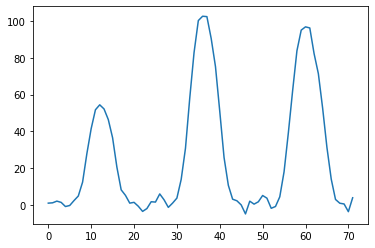

In [6]:
plt.plot(val_y1)

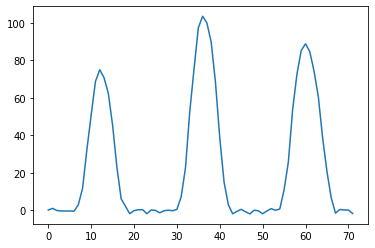

In [7]:
plt.plot(val_y2)

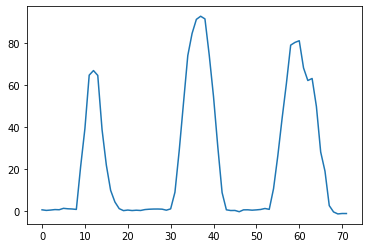

In [8]:
plt.plot(val_y3)

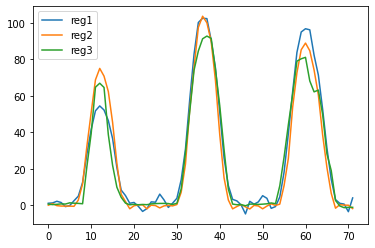

In [10]:
plt.plot(val_y1, label='reg1')
plt.plot(val_y2, label='reg2')
plt.plot(val_y3, label='reg3')
plt.legend()

In [37]:
new = val_y1*0.1 + val_y2*0.15 + val_y3*0.75
custom_loss(val_y, np.clip(new, 0, 113))

0.039725535259564154

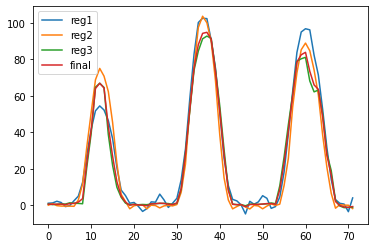

In [38]:
plt.plot(val_y1, label='reg1')
plt.plot(val_y2, label='reg2')
plt.plot(val_y3, label='reg3')
plt.plot(new, label='final')
plt.legend()

In [36]:
new = np.clip(val_y1, 0, 113)*0.1 + np.clip(val_y2, 0, 113)*0.15 + np.clip(val_y3, 0, 113)*0.75
custom_loss(val_y, np.clip(new, 0, 113))

0.03972373993444966

In [19]:
sub1 = pd.read_csv('./sub/cnn_0.0464.csv')
sub2 = pd.read_csv('./sub/cnn_0.0424.csv')
sub3 = pd.read_csv('./sub/lgb_0.0464.csv')

In [21]:
sub = sub1*0.15 + sub2*0.15 + sub3*0.7
sub = np.clip(sub, 0, 113)
sub

,0,1,2
0,0.332218,0.263724,0.874374
1,0.529751,0.026440,0.000000
2,0.859923,0.552716,0.498181
3,0.429283,0.460736,0.942047
4,0.015934,0.000000,0.123317
5,0.096459,0.030814,0.254612
6,0.322798,0.811615,3.474188
7,1.810830,10.180347,18.266160
8,5.072727,28.951433,38.754971
9,16.799105,54.247680,63.383762


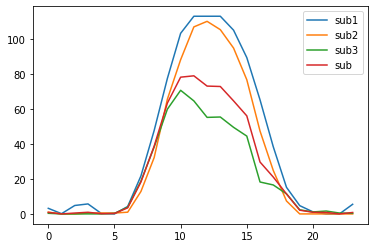

In [22]:
idx='2'
plt.plot(np.clip(sub1[idx], 0, 113), label='sub1')
plt.plot(np.clip(sub2[idx], 0, 113), label='sub2')
plt.plot(np.clip(sub3[idx], 0, 113), label='sub3')

plt.plot(sub[idx], label='sub')
plt.legend()

In [32]:
sub1

,0,1,2
0,2.406026,2.608823,3.201762
1,2.986900,0.101297,0.133521
2,5.434621,5.541740,4.820345
3,2.285515,3.844885,5.712292
4,-1.641840,-0.058127,0.296805
5,1.188826,0.786665,-0.255271
6,2.413113,4.446915,4.254526
7,8.611361,17.233526,21.705662
8,19.265562,38.652140,47.680390
9,42.797215,68.130180,77.478560


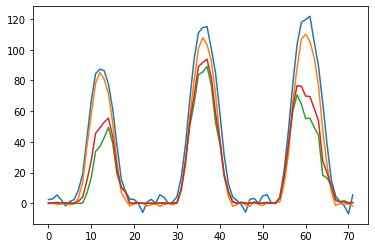

In [40]:
sub1_flat = np.hstack([sub1['0'].values,sub1['1'].values,sub1['2'].values ])
sub2_flat = np.hstack([sub2['0'].values,sub2['1'].values,sub2['2'].values ])
sub3_flat = np.hstack([sub3['0'].values,sub3['1'].values,sub3['2'].values ])
sub_flat = np.hstack([sub['0'].values,sub['1'].values,sub['2'].values ])
plt.plot(sub1_flat)
plt.plot(sub2_flat)
plt.plot(sub3_flat)
plt.plot(sub_flat)

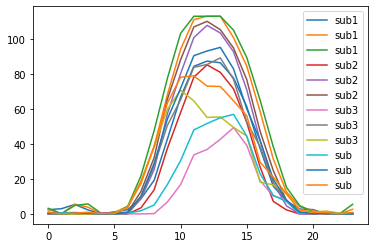

In [23]:
idx='2'
plt.plot(np.clip(sub1, 0, 113), label='sub1')
plt.plot(np.clip(sub2, 0, 113), label='sub2')
plt.plot(np.clip(sub3, 0, 113), label='sub3')

plt.plot(sub, label='sub')
plt.legend()

In [39]:
sub = sub1*0.1 + sub2*0.15 + sub3*0.75
sub = np.clip(sub, 0, 113)
sub

,0,1,2
0,0.211917,0.133283,0.731616
1,0.382093,0.026893,0.000000
2,0.599001,0.275731,0.257164
3,0.325976,0.268492,0.657329
4,0.118451,0.002071,0.108477
5,0.039926,0.000000,0.282935
6,0.204897,0.596959,3.453447
7,1.380262,9.768122,18.115620
8,4.117947,28.400606,38.283265
9,14.999277,53.372692,62.504301


In [46]:
sub.to_csv('./sub/stack_0.032.csv', index=False)